In [20]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import collections
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [4]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [5]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
 datafile,
 delimiter=",",
 usecols=range(1, 20532),
 skip_header=1
)

true_label_names = np.genfromtxt(
 labels_file,
 delimiter=",",
 usecols=(1,),
 skip_header=1,
 dtype="str"
)

In [6]:
from io import StringIO
df = pd.read_csv(StringIO(datafile))
dg = pd.read_csv(StringIO(labels_file))

In [7]:
df.fillna(0)

Empty DataFrame
Columns: [TCGA-PANCAN-HiSeq-801x20531/data.csv]
Index: []

In [8]:
data[:5, :3]
true_label_names[:5]


array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

In [9]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0], dtype=int64)

In [10]:
label_encoder.classes_

n_clusters = len(label_encoder.classes_)

In [11]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
 )

In [12]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

In [13]:
pipe = Pipeline(
     [
         ("preprocessor", preprocessor),
         ("clusterer", clusterer)
     ]
 )

In [21]:
def purity(result,label):    # 计算纯度
        total_num = len(label)
        cluster_counter = collections.Counter(result)
        original_counter = collections.Counter(label)
        t=[]
        for k in cluster_counter:
            p_k = []
            for j in original_counter:
                 count = 0
                 for i in range(len(result)):
                     if result[i] == k and label[i] == j: # 求交集
                         count += 1
                 p_k.append(count)
            temp_t = max(p_k)
            t.append(temp_t)
        return sum(t)/total_num
KKSTticks=time.perf_counter()
pipe.fit(data)
KKEDticks=time.perf_counter()

print('Kmeans所花費時間：',KKEDticks-KKSTticks)

print("min_samples=1,Kmeans的純度", purity(clusterer,true_labels))

Kmeans所花費時間： 0.9842595000000074
min_samples=1,Kmeans的純度 0.0012484394506866417


In [22]:
preprocessed_data = pipe["preprocessor"].transform(data)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

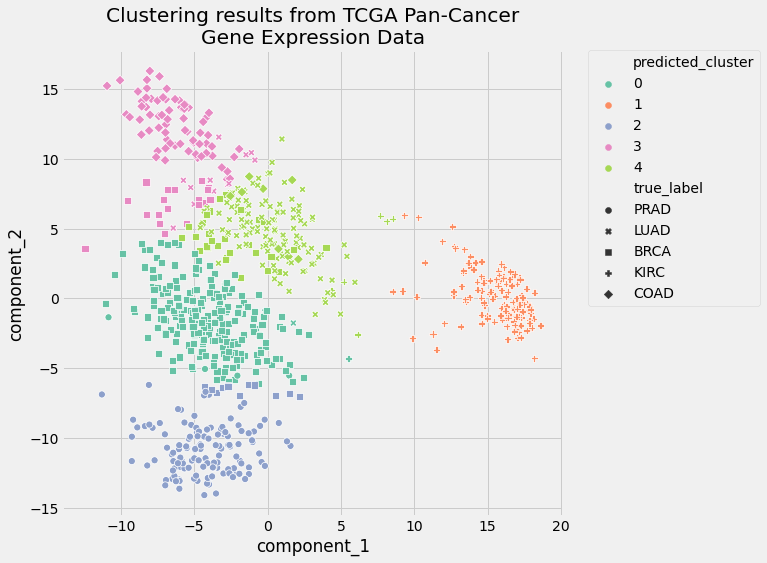

In [24]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")

plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
     "component_1",
     "component_2",
     s=50,
     data=pcadf,
     hue="predicted_cluster",
     style="true_label",
     palette="Set2",
     )
scat.set_title(
"Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [ ]:
########  DBSCAN

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
from sklearn import cluster, datasets 

n_samples = 1000
noisy_moons, _ = datasets.make_moons(n_samples=n_samples, noise=.05) 
noisy_circles, _ = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
blobs1, _ = datasets.make_blobs(n_samples=n_samples, random_state=10, center_box=(-2, 2),cluster_std=0.2)
blobs2, _ = datasets.make_blobs(n_samples=n_samples, random_state=4, center_box=(-2, 2),cluster_std=0.4)
blobs3, _ = datasets.make_blobs(n_samples=n_samples, random_state=7, center_box=(-2, 2),cluster_std=0.3)
no_structure, _ = np.random.rand(n_samples, 2), None

examples = [noisy_moons, noisy_circles, blobs1, blobs2, blobs3, no_structure]

In [28]:
df = pd.read_csv('data.csv')

In [29]:
df = df.drop(df.columns[0], axis=1)
df.head()

gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0     0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1     0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2     0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3     0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
4     0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   

     gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
0  0.591871     0.0     0.0  ...    4.926711    8.210257    9.723516   
1  0.000000     0.0     0.0  ...    4.593372    7.323865    9.740931   
2  0.452595     0.0     0.0  ...    5.125213    8.127123   10.908640   
3  0.434882     0.0     0.0  ...    6.076566    8.792959   10.141520   
4  0.360982     0.0     0.0  ...    5.996032    8.891425   10.373790   

   gene_20524  gene_20525  gene_20526  gene_20527  gene_20528  gene_20529  \
0    7.220030    9.119813   12.003135    9.650743    8.921326    5.286759   
1    6.256586    8.381612   12.674552   10.517059    9.397854    2.094168   
2    5.401607    9.911597    9.045255    9.788359   10.090470    1.683023   
3    8.942805    9.601208   11.392682    9.694814    9.684365    3.292001   
4    7.181162    9.846910   11.922439    9.217749    9.461191    5.110372   

   gene_20530  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  

[5 rows x 20531 columns]

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize

num_pipeline = Pipeline(
    [
      ("imputer", SimpleImputer(strategy="median")),
    ]
)
df_prepared = num_pipeline.fit_transform(df)
df_prepared = normalize(df_prepared)

In [31]:
from sklearn.decomposition import PCA 

pca = PCA(n_components = 2) 
df_principal = pca.fit_transform(df_prepared) 
df_principal = pd.DataFrame(df_principal) 
df_principal.columns = ['P1', 'P2'] 
df_principal

P1        P2
0   -0.056920 -0.082045
1   -0.001607  0.082631
2   -0.066280 -0.010366
3   -0.077986 -0.066873
4   -0.063931 -0.011263
..        ...       ...
796 -0.056405 -0.024994
797 -0.012920  0.050042
798  0.008534  0.024661
799 -0.050052 -0.080348
800 -0.044771 -0.043976

[801 rows x 2 columns]

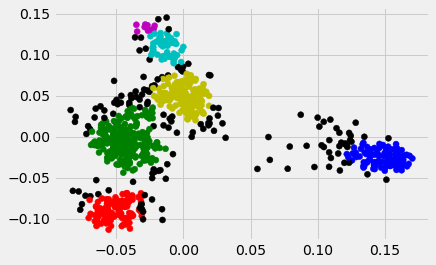

In [32]:
from sklearn.cluster import DBSCAN 

db_default = DBSCAN(eps = 0.008, min_samples = 10).fit(df_principal) 
labels = db_default.labels_ 

colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[3] = 'y'
colours[4] = 'c'
colours[5] = 'm'
colours[6] = 'tab:pink'
colours[7] = 'tab:orange'
colours[8] = 'tab:olive'
colours[9] = 'tab:brown'
colours[-1] = 'k'

cvec = [colours[label] for label in labels] 

plt.scatter(df_principal['P1'], df_principal['P2'], c = cvec) 
  
plt.show()

In [33]:
from sklearn import cluster, metrics
import collections
def purity(result,label):    # 计算纯度
        total_num = len(label)
        cluster_counter = collections.Counter(result)
        original_counter = collections.Counter(label)
        t=[]
        for k in cluster_counter:
            p_k = []
            for j in original_counter:
                 count = 0
                 for i in range(len(result)):
                     if result[i] == k and label[i] == j: # 求交集
                         count += 1
                 p_k.append(count)
            temp_t = max(p_k)
            t.append(temp_t)
        return sum(t)/total_num

KKEDticks=time.perf_counter()
print('DBSCAN所花費時間：',KKEDticks-KKSTticks)
print("min_samples=1,DBSCAN的純度", purity(labels,true_labels))

DBSCAN所花費時間： 152.32044140000005
min_samples=1,DBSCAN的純度 0.8476903870162297


In [ ]:
########### 階層

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
dataset = pd.read_csv('data.csv')
X = dataset.iloc[:, [3,4]].values

In [35]:
import scipy.cluster.hierarchy as sch

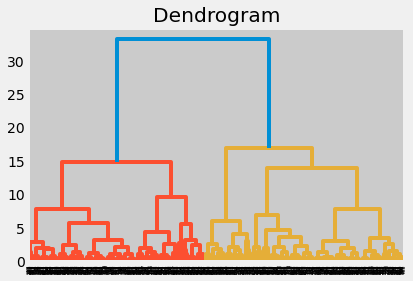

In [36]:
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [37]:
from sklearn import cluster, metrics
import collections
def purity(result,label):    # 计算纯度
        total_num = len(label)
        cluster_counter = collections.Counter(result)
        original_counter = collections.Counter(label)
        t=[]
        for k in cluster_counter:
            p_k = []
            for j in original_counter:
                 count = 0
                 for i in range(len(result)):
                     if result[i] == k and label[i] == j: # 求交集
                         count += 1
                 p_k.append(count)
            temp_t = max(p_k)
            t.append(temp_t)
        return sum(t)/total_num

KKEDticks=time.perf_counter()
print('階層所花費時間：',KKEDticks-KKSTticks)
print("min_samples=1,階層的純度", purity(labels,true_labels))

階層所花費時間： 218.35007569999993
min_samples=1,階層的純度 0.8476903870162297
